# `CausalGraphicalModels`

`CausalGraphicalModel` is a python module for describing and manipulating [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) and [Structural Causal Models](https://en.wikipedia.org/wiki/Structural_equation_modeling). Behind the curtain, it is a light wrapper around the python graph library [networkx](https://networkx.github.io/).

This notebook is designed to generate data for a causality challenge.

# StructuralCausalModels

For Structural Causal Models (SCM) we need to specify the functional form of each node:

In [21]:
def conditional(causes, probabilities, n_samples):
    # Compute conditional probabilities
    # Example
    # P(T|Causes[0]=F)=probabilities[0]
    # P(T|Causes[0]=T)=probabilities[1]
    if len(causes) == 1:
        return [np.random.binomial(n=1, p=probabilities[causes[0][i]]) for i in range(n_samples)]
    elif len(causes) == 2:
        # FF, TF, FT, TT
        return [np.random.binomial(n=1, p=probabilities[causes[0][i]][causes[1][i]]) for i in range(n_samples)]
    else:
        print('More than 2 causes, not handled.')
        return 0
    
# tests
#conditional([0], [0.1, 0.9], 5)
#conditional([0, 1], [[0.1, 0.9], [0.5, 0.5]], 5)

In [22]:
from causalgraphicalmodels import StructuralCausalModel
import numpy as np

# /!\ these values have no biological meaning, they are completely made up

scm = StructuralCausalModel({
    "born_even_day": lambda n_samples: np.random.binomial(n=1, p=0.49, size=n_samples),
    "anxiety": lambda n_samples: np.random.binomial(n=1, p=0.64277, size=n_samples),
    "peer_pressure": lambda n_samples: np.random.binomial(n=1, p=0.32997, size=n_samples),
    "genetics": lambda n_samples: np.random.binomial(n=1, p=0.15953, size=n_samples),
    "smoking": lambda anxiety, peer_pressure, n_samples: conditional([anxiety, peer_pressure], [[0.43118, 0.74591], [0.8686, 0.99351]], n_samples),
    "yellow_fingers": lambda smoking, n_samples: conditional([smoking], [0.23119, 0.95372], n_samples),
    "attention_disorder": lambda genetics, n_samples: conditional([genetics], [0.28956, 0.68706], n_samples),
    "lung_cancer": lambda smoking, genetics, n_samples: conditional([smoking, genetics], [[0.23146, 0.86996], [0.83934, 0.99351]], n_samples),
    "allergy": lambda n_samples: np.random.binomial(n=1, p=0.32841, size=n_samples),
    "coughing": lambda allergy, lung_cancer, n_samples: conditional([allergy, lung_cancer], [[0.1347, 0.7664], [0.64592, 0.99947]], n_samples),
    "fatigue": lambda coughing, lung_cancer, n_samples: conditional([coughing, lung_cancer], [[0.35212, 0.56514], [0.80016, 0.89589]], n_samples),
    "car_accident": lambda fatigue, attention_disorder, n_samples: conditional([fatigue, attention_disorder], [[0.2274, 0.779], [0.78861, 0.97169]], n_samples),
})

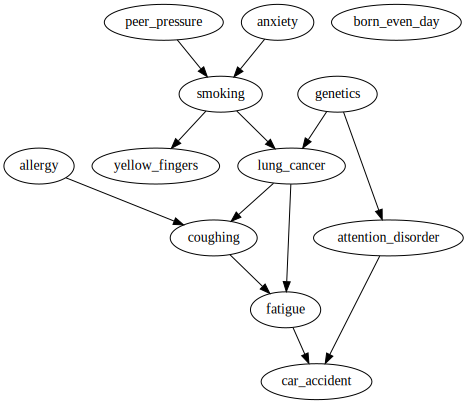

In [23]:
scm.cgm.draw()

In [35]:
data = scm.sample(n_samples=200)

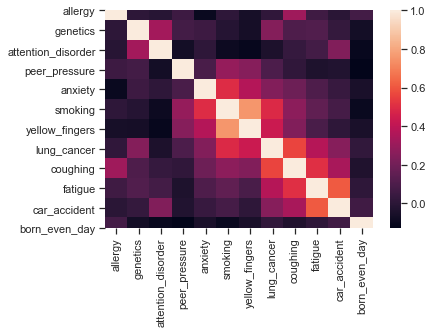

In [36]:
import autopandas
adf = autopandas.AutoData(data)
adf.corr().plot()

The only requirement on the functions are:
 - that variable names are consistent 
 - each function accepts keyword variables in the form of `numpy` arrays and output numpy arrays of shape [n_samples] 
 - that in addition to it's parents, each function takes a `n_samples` variables indicating how many samples to generate 
 - that any function acts on each row independently. This ensure that the output samples are independent
 
Wrapping these functions in the `StructuralCausalModel` object allows us to easily generate samples: 

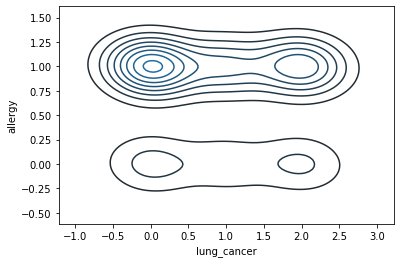

In [4]:
# and visualise the samples
import seaborn as sns

%matplotlib inline

sns.kdeplot(
    data=ds.lung_cancer,
    data2=ds.allergy,
)

And to access the implied CGM"

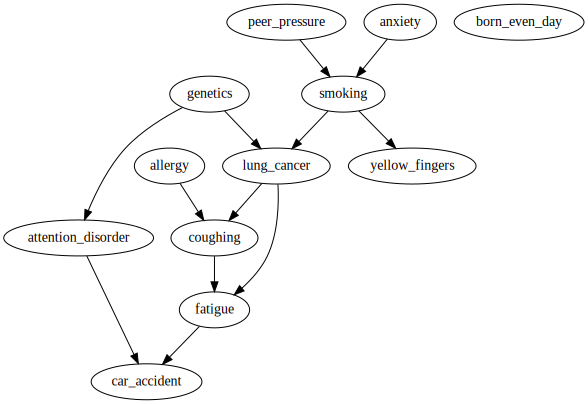

In [5]:
scm.cgm.draw()

And to apply an intervention:

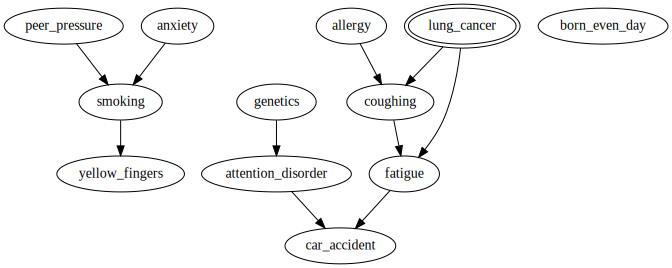

In [6]:
scm_do = scm.do("lung_cancer")

scm_do.cgm.draw()

And sample from the distribution implied by this intervention:

In [7]:
scm_do.sample(n_samples=5, set_values={"lung_cancer": np.arange(5)})

,allergy,lung_cancer,coughing,fatigue,genetics,attention_disorder,car_accident,peer_pressure,anxiety,smoking,yellow_fingers,born_even_day
0,0,0,0,0,1,1,0,0,0,0,-0.069327,1
1,1,1,2,3,1,1,3,1,1,2,1.989477,1
2,1,2,3,5,1,1,5,1,1,2,2.020766,1
3,0,3,3,6,1,1,6,1,1,2,1.952722,1
4,1,4,5,9,1,1,9,0,1,1,0.962361,0
